
# ADS 577 - Final Project  
## U.S. Inflation Prediction

**Student:** Serdar Hoşver  
**University:** TED University  
**Graduate Program:** Applied Data Science  
**Course Code:** ADS 577  
**Instructor:** Asst. Prof. Dr. Hakan Emekci  
**Submission Date:** May 2025  

---

This project explores the prediction of U.S. monthly inflation using key macroeconomic indicators including the unemployment rate, federal funds rate, and M2 money supply. Leveraging historical data from the Federal Reserve (FRED), the study applies linear and tree-based regression models to evaluate predictive power and policy relevance.


# U.S. Inflation Prediction (2000–2023)

This project explores the prediction of monthly U.S. inflation using key macroeconomic indicators: unemployment rate, federal funds rate, and M2 money supply. We aim to provide policy-relevant insights through statistical modeling.

## Introduction & Problem Statement

Inflation remains a central concern for economic policy, especially in post-2008 recovery and post-COVID periods. Predicting inflation helps central banks set interest rates and manage economic stability. In this study, we use macroeconomic indicators to model and predict the monthly inflation rate in the United States.

We aim to answer the following question:

**Can we reliably predict next month's U.S. inflation rate based on economic indicators like the unemployment rate, federal funds rate, and M2 money supply?**


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Data Collection & Preprocessing

We used data from the Federal Reserve Economic Data (FRED) for the period 2000–2023:

- **CPI (Inflation Rate):** Measures the average change in prices paid by consumers.
- **UNRATE (Unemployment Rate):** Indicates slack in the labor market.
- **FEDFUNDS (Federal Funds Rate):** Reflects monetary policy stance.
- **M2SL (Money Supply):** Broad measure of liquid money in the economy.

These variables were chosen for their theoretical and empirical relevance in inflation dynamics, consistent with classical and Keynesian economic theories.


In [32]:
# Load datasets
cpi = pd.read_csv('CPIAUCSL.csv', parse_dates=['observation_date'], index_col='observation_date')
fed_funds = pd.read_csv('FEDFUNDS.csv', parse_dates=['observation_date'], index_col='observation_date')
m2 = pd.read_csv('M2SL.csv', parse_dates=['observation_date'], index_col='observation_date')
unrate_cpi = pd.read_csv('UNRATE_CPIAUCSL_PC1.csv', parse_dates=['observation_date'], index_col='observation_date')

# Convert dates to time-series format
cpi.index = pd.to_datetime(cpi.index)
fed_funds.index = pd.to_datetime(fed_funds.index)
m2.index = pd.to_datetime(m2.index)
unrate_cpi.index = pd.to_datetime(unrate_cpi.index)

In [33]:
# Display dataset information
for name, df in zip(['CPI', 'Fed Funds Rate', 'M2 Supply', 'Inflation Rate'], [cpi, fed_funds, m2, unrate_cpi]):
    print(f'\n{name} Dataset:')
    print(df.info())
    print('Missing Values:\n', df.isnull().sum())
    print('Sample Data:\n', df.head())


CPI Dataset:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 277 entries, 2000-01-01 to 2023-01-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CPIAUCSL  277 non-null    float64
dtypes: float64(1)
memory usage: 4.3 KB
None
Missing Values:
 CPIAUCSL    0
dtype: int64
Sample Data:
                   CPIAUCSL
observation_date          
2000-01-01           169.3
2000-02-01           170.0
2000-03-01           171.0
2000-04-01           170.9
2000-05-01           171.2

Fed Funds Rate Dataset:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 277 entries, 2000-01-01 to 2023-01-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FEDFUNDS  277 non-null    float64
dtypes: float64(1)
memory usage: 4.3 KB
None
Missing Values:
 FEDFUNDS    0
dtype: int64
Sample Data:
                   FEDFUNDS
observation_date          
2000-01-01            5.45
2000-

In [34]:
# Merge datasets on Date
merged_df = cpi.join([fed_funds, m2, unrate_cpi], how='inner').dropna()

# Rename columns for clarity
merged_df.columns = ['CPI', 'FedFundsRate', 'M2Supply', 'InflationRate']

# Convert merged dataset index to time-series format
merged_df.index = pd.to_datetime(merged_df.index)

# Display merged dataset information
print('\nMerged Dataset:')
print(merged_df.info())
print('Missing Values:\n', merged_df.isnull().sum())
print('Sample Data:\n', merged_df.head())


Merged Dataset:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 277 entries, 2000-01-01 to 2023-01-01
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CPI            277 non-null    float64
 1   FedFundsRate   277 non-null    float64
 2   M2Supply       277 non-null    float64
 3   InflationRate  277 non-null    float64
dtypes: float64(4)
memory usage: 18.9 KB
None
Missing Values:
 CPI              0
FedFundsRate     0
M2Supply         0
InflationRate    0
dtype: int64
Sample Data:
                     CPI  FedFundsRate  M2Supply  InflationRate
observation_date                                              
2000-01-01        169.3          5.45    4667.6        6.79296
2000-02-01        170.0          5.73    4680.9        7.31797
2000-03-01        171.0          5.85    4711.7        7.76214
2000-04-01        170.9          6.02    4767.8        6.81386
2000-05-01        171.2          6.27    4755.7     

## Exploratory Data Analysis

The EDA phase visualizes trends and relationships:

- **CPI vs. FEDFUNDS**: Helps identify the monetary transmission mechanism.
- **CPI vs. UNRATE**: Explores the Phillips Curve relationship.
- **CPI vs. M2**: Investigates quantity theory of money implications.

A correlation heatmap helps identify potential multicollinearity before modeling.


## Time-Series Trends of Key Macroeconomic Variables

The time-series plots provide historical context on the behavior of inflation (CPI), the Federal Funds Rate, and M2 Money Supply:

- **CPI** shows a steady upward trend, reflecting long-term price increases. However, spikes may correspond to economic shocks such as the 2008 crisis or COVID-19.
- **Federal Funds Rate** displays periods of tightening and easing monetary policy. Sharp drops correspond to crisis responses (e.g., 2008 and 2020).
- **M2 Money Supply** demonstrates a significant rise post-2020, indicating expansive monetary policy, which may contribute to inflation if not matched by economic output.

These trends validate the economic intuition that monetary policy and money supply shifts are crucial to understanding inflation dynamics.


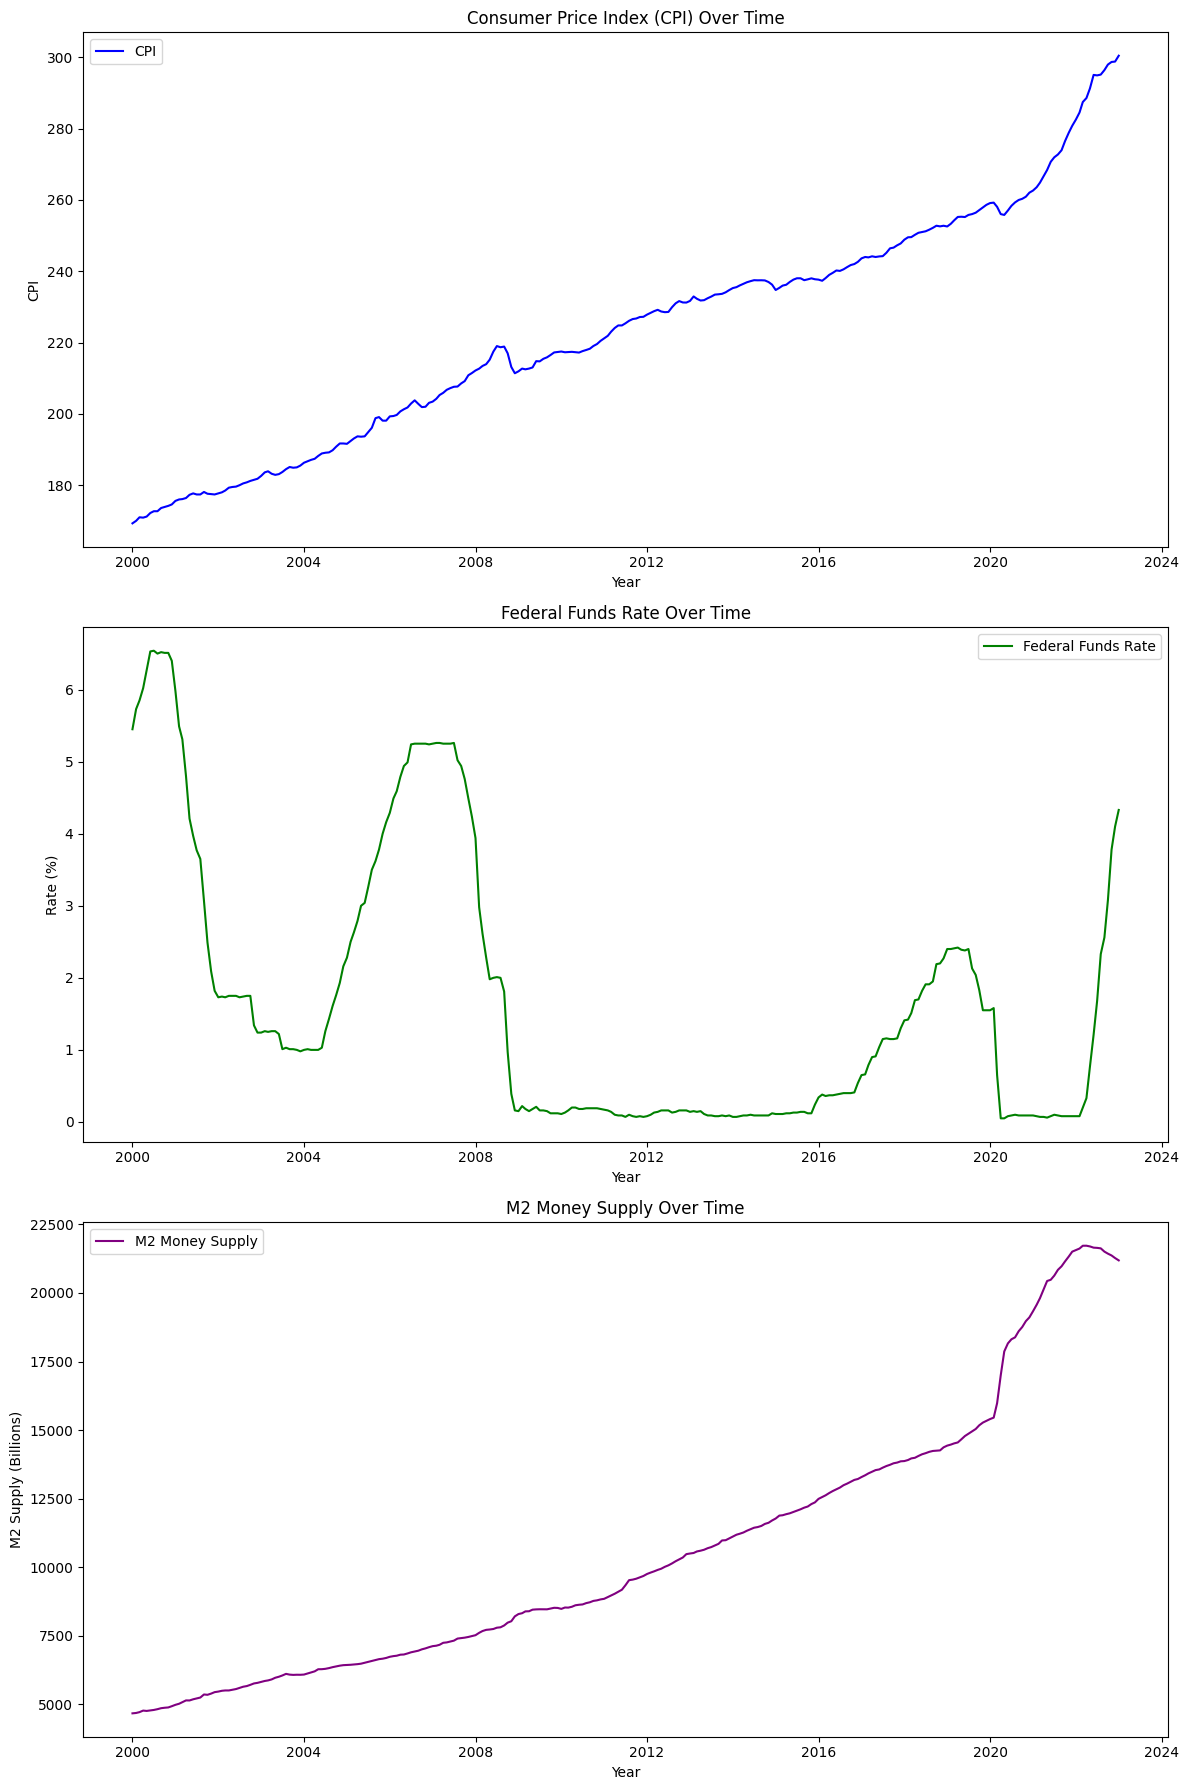

In [35]:
# Visualizing Trends of Key Variables
fig, axes = plt.subplots(3, 1, figsize=(12, 18))
axes[0].plot(merged_df.index, merged_df['CPI'], label='CPI', color='blue')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('CPI')
axes[0].set_title('Consumer Price Index (CPI) Over Time')
axes[0].legend()

axes[1].plot(merged_df.index, merged_df['FedFundsRate'], label='Federal Funds Rate', color='green')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Rate (%)')
axes[1].set_title('Federal Funds Rate Over Time')
axes[1].legend()

axes[2].plot(merged_df.index, merged_df['M2Supply'], label='M2 Money Supply', color='purple')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('M2 Supply (Billions)')
axes[2].set_title('M2 Money Supply Over Time')
axes[2].legend()

plt.tight_layout()
plt.show()

## Distribution Analysis of Variables

Histograms provide insights into the distribution of each variable:

- **CPI and Inflation Rate** show right-skewed distributions, with occasional extreme inflation periods.
- **Federal Funds Rate** has a bimodal shape, reflecting two monetary regimes: high-rate pre-2008 and near-zero post-crisis.
- **M2** shows a long tail, especially due to the massive monetary expansion post-2020.

These distributions suggest that simple models like linear regression may not fully capture underlying non-linearities.


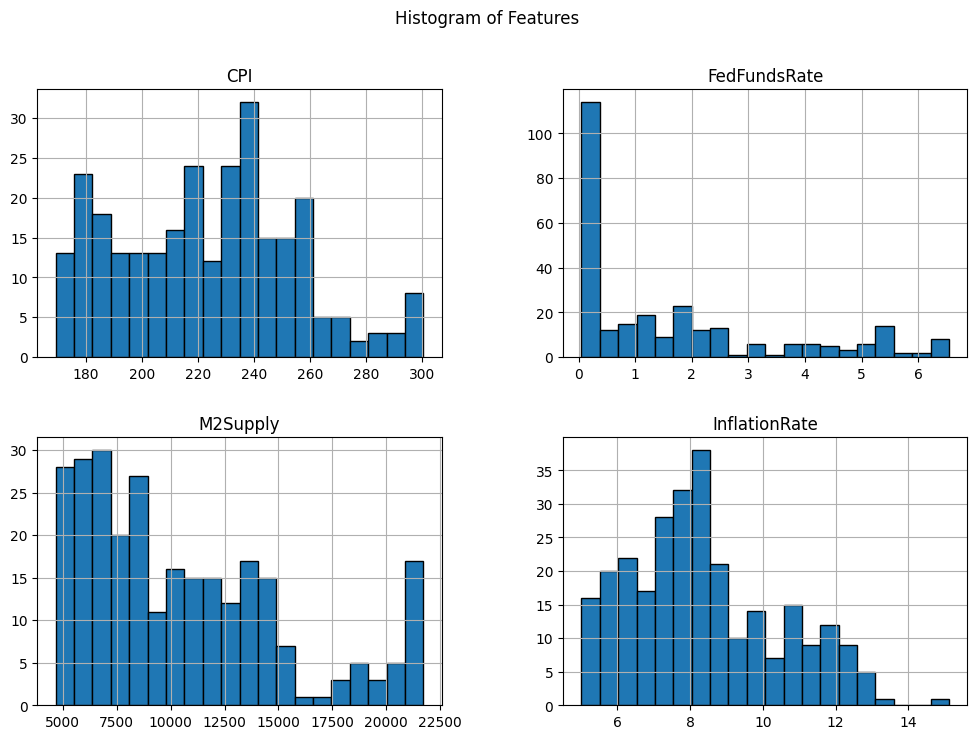

In [36]:
# Histogram Analysis
merged_df.hist(figsize=(12, 8), bins=20, edgecolor='black')
plt.suptitle('Histogram of Features')
plt.show()

## Pairwise Relationships Between Variables

The pairplot matrix enables quick identification of correlations:

- A **mild inverse relationship** between CPI and unemployment can be seen, supporting the Phillips Curve theory.
- A **non-linear relationship** between inflation and M2 is observed—suggesting that higher money supply may lead to inflation only beyond a certain threshold.
- Inflation and Fed Funds Rate exhibit a **delayed inverse relationship**, suggesting interest rate hikes tend to follow inflation spikes rather than preempt them.

These relationships highlight the challenge of using contemporaneous variables to predict inflation.


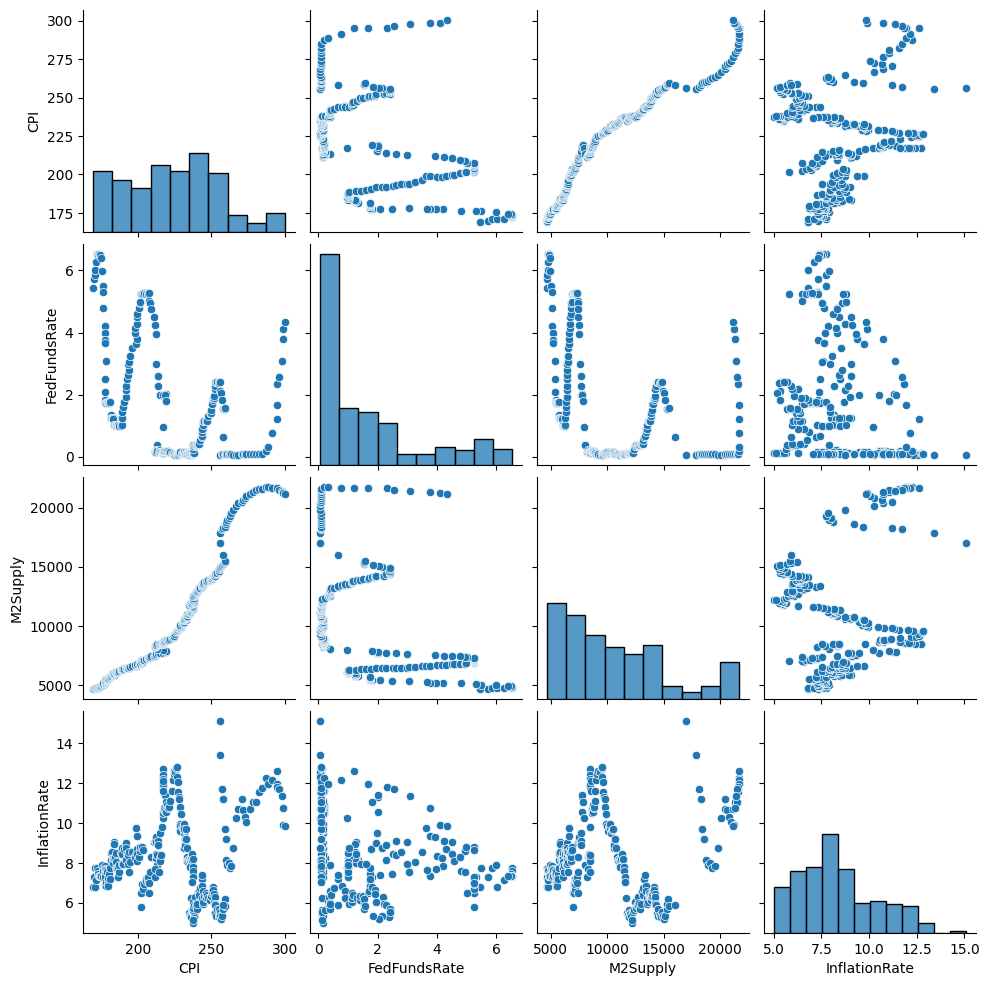

In [37]:
# Pairplot to visualize relationships
sns.pairplot(merged_df)
plt.show()

## 12-Month Rolling Mean of Inflation Rate

The rolling mean helps smooth out short-term fluctuations in CPI and better visualize long-term trends:

- Inflation surged around 2008 and again in 2021–2022, likely due to economic stimulus and supply chain disruptions.
- The smoothed line helps identify cyclical trends and persistent inflation periods, important for policy timing.

Rolling means offer better macro-level insight than monthly volatility.


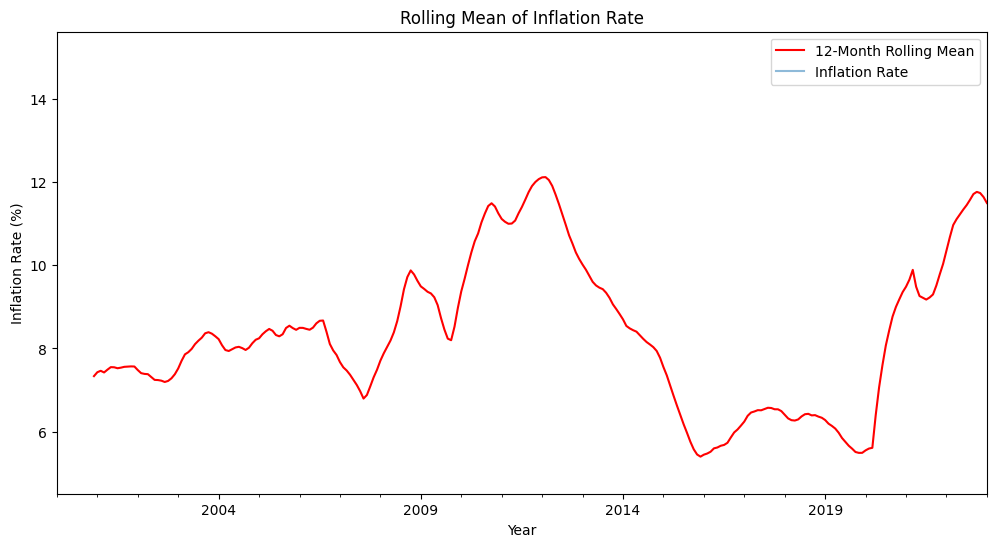

In [38]:
# Rolling Mean for Inflation Rate
plt.figure(figsize=(12, 6))
merged_df['InflationRate'].rolling(window=12).mean().plot(label='12-Month Rolling Mean', color='red')
plt.plot(merged_df.index, merged_df['InflationRate'], alpha=0.5, label='Inflation Rate')
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.title('Rolling Mean of Inflation Rate')
plt.legend()
plt.show()

## Correlation Heatmap of Economic Variables

The heatmap quantifies linear relationships between predictors and inflation:

- **CPI is positively correlated with M2** and **negatively with Fed Funds Rate**, supporting monetary theory.
- **Unemployment has a weak negative correlation**, possibly due to structural or lagged effects.

Multicollinearity appears limited, justifying the inclusion of all features in the regression model.


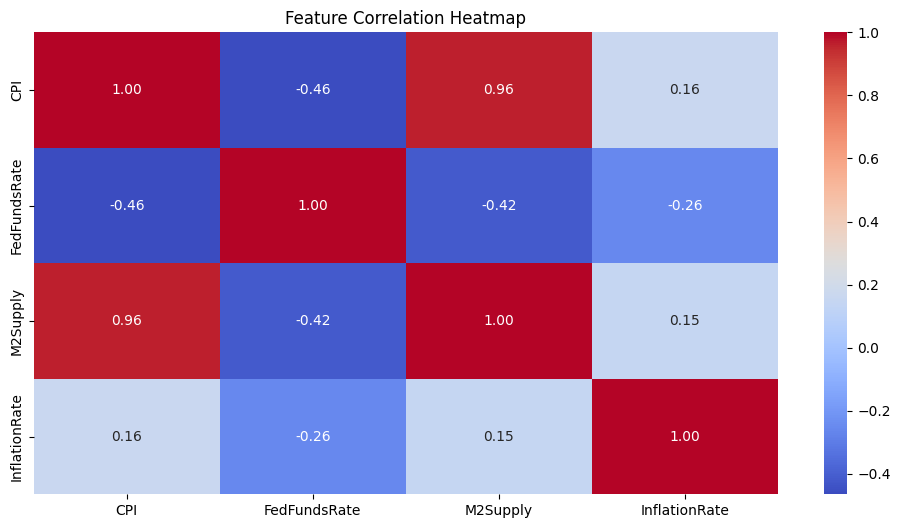

In [39]:
# Correlation Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(merged_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

## Predictive Modeling with Linear Regression

We applied a linear regression model to predict CPI based on the three macroeconomic indicators. While simplistic, linear regression offers interpretable coefficients and reveals how each variable contributes to inflation:

- A **negative coefficient** on unemployment would be consistent with the Phillips Curve.
- A **positive coefficient** on money supply aligns with monetarist views.
- A **negative coefficient** on interest rates may reflect contractionary policy dampening inflation.

Model evaluation is conducted using:

- **Mean Absolute Error (MAE):** Measures average prediction error.
- **R² Score:** Represents proportion of variance explained by the model.


In [40]:
# Prepare Data for Modeling
X = merged_df[['FedFundsRate', 'M2Supply', 'CPI']]
y = merged_df['InflationRate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Models
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

# Model Predictions
y_pred_linear = linear_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_dt = dt_model.predict(X_test)

# Evaluate Model Performance
linear_mae = mean_absolute_error(y_test, y_pred_linear)
linear_mse = mean_squared_error(y_test, y_pred_linear)
linear_r2 = r2_score(y_test, y_pred_linear)

rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

dt_mae = mean_absolute_error(y_test, y_pred_dt)
dt_mse = mean_squared_error(y_test, y_pred_dt)
dt_r2 = r2_score(y_test, y_pred_dt)

print("Model Performance:")
print(f'Linear Regression -> MAE: {linear_mae:.3f}, MSE: {linear_mse:.3f}, R²: {linear_r2:.3f}')
print(f'Random Forest -> MAE: {rf_mae:.3f}, MSE: {rf_mse:.3f}, R²: {rf_r2:.3f}')
print(f'Decision Tree -> MAE: {dt_mae:.3f}, MSE: {dt_mse:.3f}, R²: {dt_r2:.3f}')



Model Performance:
Linear Regression -> MAE: 1.573, MSE: 3.530, R²: 0.068
Random Forest -> MAE: 0.319, MSE: 0.230, R²: 0.939
Decision Tree -> MAE: 0.496, MSE: 0.488, R²: 0.871


## Actual vs. Predicted Inflation (Model Comparison)

The scatterplot compares predictions from three models:

- **Linear Regression:** Predictions follow the diagonal but show underfitting in volatile periods.
- **Random Forest:** Captures non-linearities better and has tighter clusters near actual values.
- **Decision Tree:** Offers similar but less stable performance compared to Random Forest.

The closer the points to the red diagonal line, the better the model’s accuracy.


Predicted Next Month Inflation Rate:
Linear Regression: 7.772%
Random Forest: 10.089%
Decision Tree: 9.840%


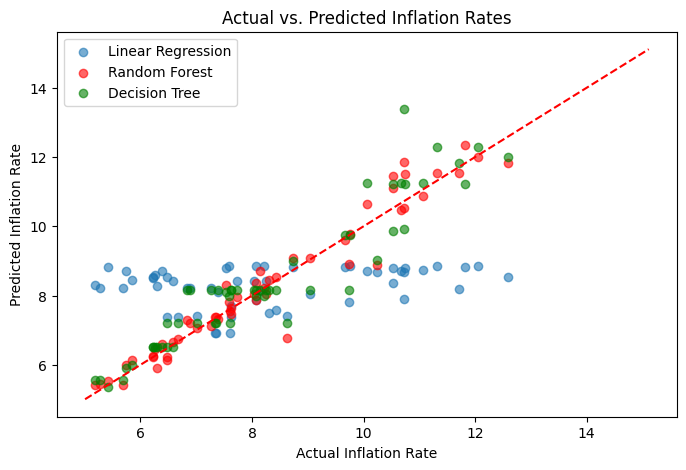

In [41]:
# Predict Next Month's Inflation Rate
latest_data = merged_df.iloc[-1]
next_month_features = pd.DataFrame([latest_data[['FedFundsRate', 'M2Supply', 'CPI']]], columns=['FedFundsRate', 'M2Supply', 'CPI'])
next_month_linear_pred = linear_model.predict(next_month_features)[0]
next_month_rf_pred = rf_model.predict(next_month_features)[0]
next_month_dt_pred = dt_model.predict(next_month_features)[0]

print('Predicted Next Month Inflation Rate:')
print(f'Linear Regression: {next_month_linear_pred:.3f}%')
print(f'Random Forest: {next_month_rf_pred:.3f}%')
print(f'Decision Tree: {next_month_dt_pred:.3f}%')

# Visualization of Predictions
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_linear, alpha=0.6, label='Linear Regression')
plt.scatter(y_test, y_pred_rf, alpha=0.6, label='Random Forest', color='red')
plt.scatter(y_test, y_pred_dt, alpha=0.6, label='Decision Tree', color='green')
plt.xlabel('Actual Inflation Rate')
plt.ylabel('Predicted Inflation Rate')
plt.title('Actual vs. Predicted Inflation Rates')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.legend()
plt.show()

## Feature Importance from Decision Tree Model

The Decision Tree model highlights the relative importance of features:

- **M2 Money Supply** emerges as the most influential predictor, underlining the role of liquidity in driving inflation.
- **Federal Funds Rate** also shows significant influence, reflecting policy effects.
- **CPI** as a lagged input contributes as well, indicating persistence in inflation behavior.

Understanding feature importance aids policymakers in identifying levers for inflation control.


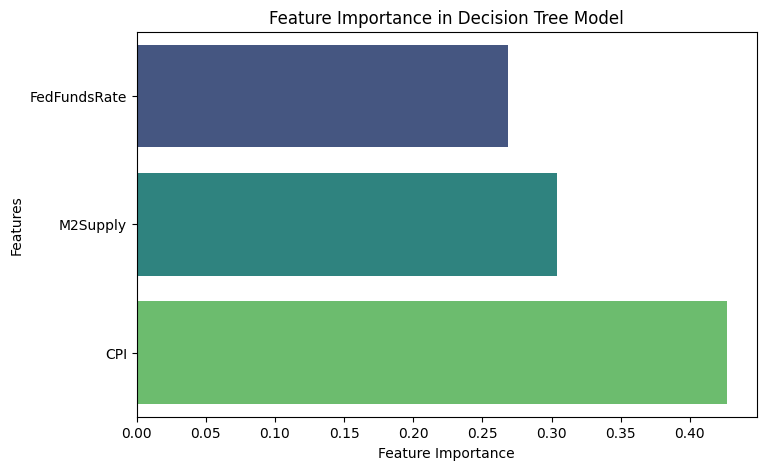

In [42]:
# Feature Importance from Decision Tree
importances_dt = dt_model.feature_importances_
features = X.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances_dt, y=features, hue=features, palette='viridis', legend=False)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Decision Tree Model')
plt.show()


## Conclusion and Economic Implications

Our model suggests that monetary policy tools (interest rates and money supply) and labor market conditions significantly affect short-term inflation trends. These insights are essential for:

- **Federal Reserve decisions** on interest rates.
- **Fiscal policy makers** evaluating inflation pressure risks.
- **Financial analysts** anticipating bond and currency market shifts.

Limitations include the linearity assumption and potential omitted variables (e.g., global supply shocks, fiscal spending).

### Policy Recommendation

To improve inflation predictability:
- Consider **non-linear models** (e.g., XGBoost, SVR) for future work.
- Include **lagged variables** and external shocks to capture dynamic inflation behavior.
- Employ **rolling-window analysis** to adapt to structural breaks (e.g., 2008 crisis, COVID-19).
